In [1]:
#Name_length extraction
#Title_extraction
#Family_size(sibsp+parch)
#group_of ticket
#categorized cabin
#(Try cabin categories as 10s and pclass as from 0-9 )
#(Try cabin categories as 10s and fare class as power and pclass as from 0-9*10power(fare class))(and try logging it after)
#Age_impute

In [2]:
import sys
assert sys.version_info >= (3, 7)

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
import re
from sklearn.ensemble import RandomForestRegressor
from google.colab import drive
import joblib
import sys
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import tarfile
from pathlib import Path
import urllib.request

loading data

In [4]:
def load_data(path,url):
  FPath=Path(path)
  Path("datasets").mkdir(parents=True,exist_ok=True)
  urllib.request.urlretrieve(url,FPath)
  with tarfile.open(FPath) as data_tarball:
     data_tarball.extractall(path="datasets")
  return pd.read_csv(Path("/content/datasets/titanic/train.csv"))

In [5]:
Training_data=load_data(path="datasets/titanic.tgz",url="https://homl.info/titanic.tgz")

/tmp/ipython-input-59008250.py:6: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  data_tarball.extractall(path="datasets")


In [6]:
Test_data=pd.read_csv(Path("/content/datasets/titanic/test.csv"))

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
sys.path.append('/content/drive/MyDrive/models')


# loading age imputer

In [9]:
import IMP_AGE

for name, obj in IMP_AGE.__dict__.items():
    if not name.startswith("__"):
        setattr(sys.modules['__main__'], name, obj)

In [10]:
#fitted column transformer for age imputing
CTransformer=joblib.load("/content/drive/MyDrive/models/Age_Col_transofrmer.joblib")

In [11]:
# a trained and tested RandomForestRegressor to impute NaaN Age values,scored 10.6 RMSE, 0.43 R2
     #contributed to a increase of 2% of correct survival predictions
Age_imputer=joblib.load("/content/drive/MyDrive/models/Age_imputer.model")

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

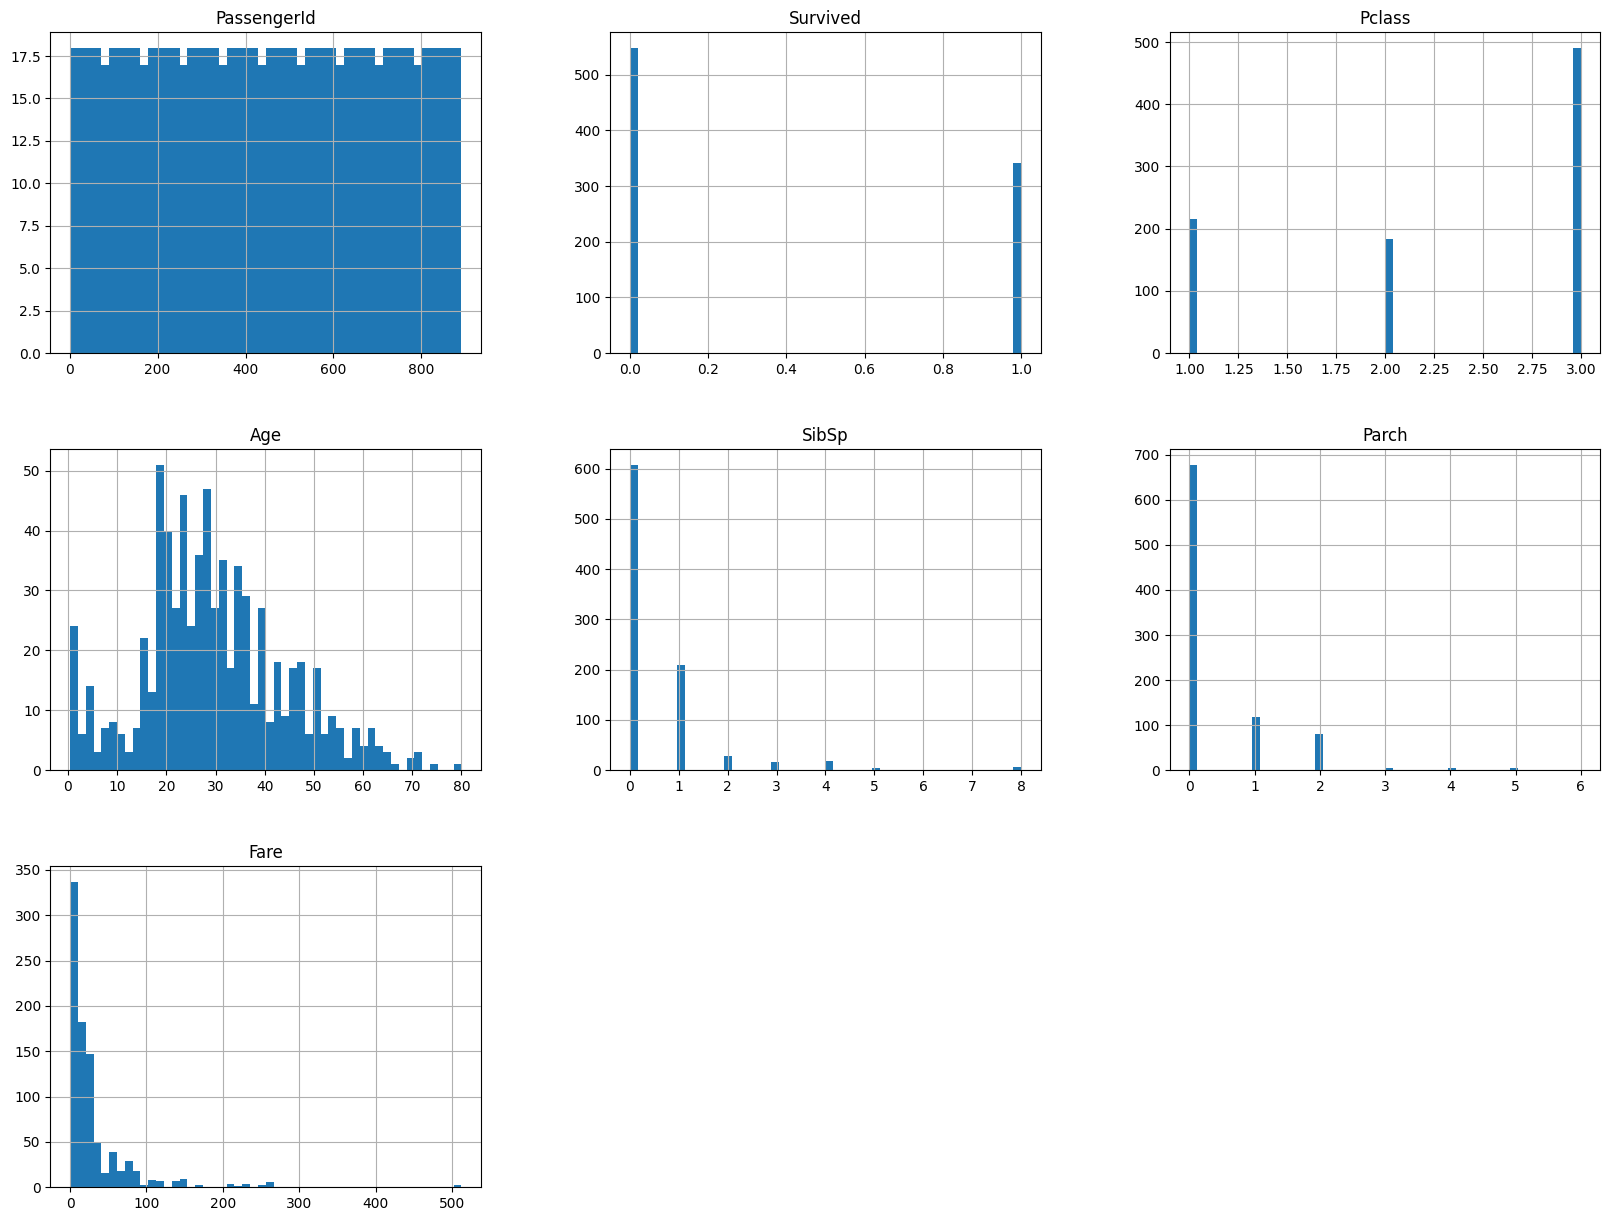

In [12]:
Training_data.hist(bins=50,figsize=(20,15))

In [13]:
Test_data['Fare'].fillna(value=13.3,axis=0,inplace=True)

/tmp/ipython-input-907674222.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Test_data['Fare'].fillna(value=13.3,axis=0,inplace=True)


In [14]:
training_To_impute=Training_data.loc[Training_data['Age'].isna()]
Test_data_To_impute=Test_data.loc[Test_data['Age'].isna()]

In [15]:
training_To_impute_transformed=CTransformer.transform(training_To_impute)
Test_data_To_impute_transformed=CTransformer.transform(Test_data_To_impute)

In [16]:
training_To_impute_Age=pd.DataFrame(training_To_impute_transformed,columns=CTransformer.get_feature_names_out())
Test_data_To_impute_Age=pd.DataFrame(Test_data_To_impute_transformed,columns=CTransformer.get_feature_names_out())

In [17]:
training_To_impute_Age.drop('passthrough__Age',axis=1,inplace=True)
Test_data_To_impute_Age.drop('passthrough__Age',axis=1,inplace=True)

In [18]:
training_imputed=Age_imputer.predict(training_To_impute_Age)
Test_imputed=Age_imputer.predict(Test_data_To_impute_Age)

In [19]:
training_to_fill_AGE=pd.DataFrame(training_imputed,columns=['AGE'],index=Training_data.loc[Training_data['Age'].isna()].index)
test_to_fill_AGE=pd.DataFrame(Test_imputed,columns=['AGE'],index=Test_data.loc[Test_data['Age'].isna()].index)

In [56]:
training_to_fill_AGE.head()

,AGE
5,34.805314
17,32.795825
19,32.811350
26,27.142925
28,22.873305


In [21]:
for i in range (training_to_fill_AGE.shape[0]):
  Training_data.loc[Training_data.index==training_to_fill_AGE.index[i],'Age']=training_to_fill_AGE.loc[training_to_fill_AGE.index[i],'AGE']

In [22]:
for i in range (test_to_fill_AGE.shape[0]):
  Test_data.loc[Test_data.index==test_to_fill_AGE.index[i],'Age']=test_to_fill_AGE.loc[test_to_fill_AGE.index[i],'AGE']

In [59]:
Training_data.loc[Training_data.index==5,'Age']

,Age
5,34.805314


name length feature

In [23]:
def Name_length(Names):
   Y=[]
   for i in range(Names.shape[0]):
       Y.append(len(Names.iloc[i,0]))
   return np.reshape(np.array(Y),(Names.shape[0],1))

name_length=FunctionTransformer(Name_length,feature_names_out="one-to-one")

In [24]:
Training_data_copy=Training_data
Test_data_copy=Test_data

Training_data_copy['Name_Length']=name_length.transform(Training_data_copy[['Name']])
Test_data_copy['Name_Length']=name_length.transform(Test_data_copy[['Name']])

title feature

In [25]:
def extract_title(X):
  k=[]
  for i in range(X.shape[0]):
      Title=re.search(r' ([A-Za-z]+)\.',X.iloc[i,0]).group(1)
      if Title in ['Capt','Col','Don','Dr','Jonkheer','Major','Rev','Sir','Mr','Countess','Dona','Lady','Mrs']:
        k.append('Mr')
      else:
        k.append('Master')
  return np.reshape(np.array(k),(X.shape[0],1))


def title_names(K,X):
  L=[]
  for i in range (len(X)):
     M=f'{X[i]}_title'
     L.append(M)
  return L


Title_Extractor=FunctionTransformer(extract_title,feature_names_out=title_names)

In [26]:
Title_Pipe=Pipeline(
    [('Title_Extraction',Title_Extractor),
     ('Title_one_hot',OneHotEncoder(sparse_output=False))]
)

In [27]:
Training_data_copy[['Title_Cat_Master','Title_Cat_Mr']]=Title_Pipe.fit_transform(Training_data_copy[['Name']])
Test_data_copy[['Title_Cat_Master','Title_Cat_Mr']]=Title_Pipe.fit_transform(Test_data_copy[['Name']])

sex encoding

In [28]:
sex_encoder=OneHotEncoder(sparse_output=False)
Training_data_copy[['Sex_Encoded_Female','Sex_Encoded_Male']]=sex_encoder.fit_transform(Training_data_copy[['Sex']])
Test_data_copy[['Sex_Encoded_Female','Sex_Encoded_Male']]=sex_encoder.transform(Test_data_copy[['Sex']])

family size feature

In [29]:
def Family_size(X):
  k=X.iloc[:,0]+X.iloc[:,1]+1
  return k

Family_sizer=FunctionTransformer(Family_size,feature_names_out="one-to-one")

In [30]:
Training_data_copy['Family_Size']=Family_sizer.transform(Training_data_copy[['SibSp','Parch']])
Test_data_copy['Family_Size']=Family_sizer.transform(Test_data_copy[['SibSp','Parch']])

In [31]:
Training_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Name_Length',
       'Title_Cat_Master', 'Title_Cat_Mr', 'Sex_Encoded_Female',
       'Sex_Encoded_Male', 'Family_Size'],
      dtype='object')

# custom transformer for extracting the number of people with the same ticket

In [32]:
class SameTicketCount(TransformerMixin, BaseEstimator):
   def __init__(self):
    self.valid=False
   def fit(self,X,Y=None):
    groups=X.groupby('Ticket')
    self.thing=groups['Ticket'].count().sort_values(ascending=True)
    self.valid=True
    return self

   def transform(self,X):
    M=[]
    for i in range(X.shape[0]):
      M.append(self.thing[X.iloc[i,0]])
    return  np.reshape(np.array(M),(X.shape[0],1))

   def get_feature_names_out(self, input_feature=None):
    if input_feature is None:
          input_feature= ["Group_Of"]
    return input_feature



Ticket_GroupCount=SameTicketCount()

fitted on the tickets of all the data

In [33]:
Full_Data=pd.concat([Training_data,Test_data])
Full_Data.reset_index(drop=True,inplace=True)

In [34]:
Ticket_GroupCount.fit(Full_Data[['Ticket']])

SameTicketCount()

In [35]:
Training_data['Group_of']=Ticket_GroupCount.transform(Training_data[['Ticket']])
Test_data['Group_of']=Ticket_GroupCount.transform(Test_data[['Ticket']])

Embarked encoding

In [36]:
Embarked_Pipe=Pipeline(
    [('embarked_imputation',SimpleImputer(strategy='most_frequent')),
     ('embarked_one_hot',OneHotEncoder(sparse_output=False))]
)

In [37]:
Training_data_copy[['Embarked_Encoded_1','Embarked_Encoded_2','Embarked_Encoded_3']]=Embarked_Pipe.fit_transform(Training_data_copy[['Embarked']])
Test_data_copy[['Embarked_Encoded_1','Embarked_Encoded_2','Embarked_Encoded_3']]=Embarked_Pipe.transform(Test_data_copy[['Embarked']])

In [38]:
Training_data_copy1=Training_data_copy
Test_data_copy1=Test_data_copy

In [39]:
corr_matrix = Training_data_copy1.corr(numeric_only=True)
corr_matrix["Survived"].sort_values(ascending=False)

,Survived
Survived,1.000000
Sex_Encoded_Female,0.543351
Title_Cat_Master,0.356716
Name_Length,0.332039
Fare,0.257307
Embarked_Encoded_1,0.168240
Parch,0.081629
Group_of,0.064962
Family_Size,0.016639
Embarked_Encoded_2,0.003650


fare/person feature

In [40]:
Training_data_copy1['Fare_PER_Person']=Training_data_copy1['Fare']/(Training_data_copy1['Group_of'])
Test_data_copy1['Fare_PER_Person']=Test_data_copy1['Fare']/(Test_data_copy1['Group_of'])

In [41]:
Test_data_copy1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         418 non-null    int64  
 1   Pclass              418 non-null    int64  
 2   Name                418 non-null    object 
 3   Sex                 418 non-null    object 
 4   Age                 418 non-null    float64
 5   SibSp               418 non-null    int64  
 6   Parch               418 non-null    int64  
 7   Ticket              418 non-null    object 
 8   Fare                418 non-null    float64
 9   Cabin               91 non-null     object 
 10  Embarked            418 non-null    object 
 11  Name_Length         418 non-null    int64  
 12  Title_Cat_Master    418 non-null    float64
 13  Title_Cat_Mr        418 non-null    float64
 14  Sex_Encoded_Female  418 non-null    float64
 15  Sex_Encoded_Male    418 non-null    float64
 16  Family_S

In [42]:
columnsss=Training_data_copy1.select_dtypes(include=['object']).columns.to_list()
columnsss.append('PassengerId')
Test_data_copy1.drop(columns=columnsss,inplace=True)
SURVIVED=Training_data_copy1['Survived']
columnsss.append('Survived')
Training_data_copy1.drop(columns=columnsss,inplace=True)


In [43]:
Training_data_copy1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              891 non-null    int64  
 1   Age                 891 non-null    float64
 2   SibSp               891 non-null    int64  
 3   Parch               891 non-null    int64  
 4   Fare                891 non-null    float64
 5   Name_Length         891 non-null    int64  
 6   Title_Cat_Master    891 non-null    float64
 7   Title_Cat_Mr        891 non-null    float64
 8   Sex_Encoded_Female  891 non-null    float64
 9   Sex_Encoded_Male    891 non-null    float64
 10  Family_Size         891 non-null    int64  
 11  Group_of            891 non-null    int64  
 12  Embarked_Encoded_1  891 non-null    float64
 13  Embarked_Encoded_2  891 non-null    float64
 14  Embarked_Encoded_3  891 non-null    float64
 15  Fare_PER_Person     891 non-null    float64
dtypes: float

In [44]:
RANDOM_FOREST_CLASSER=RandomForestClassifier(random_state=25)

cross validated the model then decided to further fine tune and then select and predict

In [45]:
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [None, 20, 40, 60],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf':[1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

scoring = {'accuracy': 'accuracy', 'f1': 'f1'}

In [46]:
grid=GridSearchCV(estimator=RANDOM_FOREST_CLASSER,
                  param_grid=param_grid,
                  scoring=scoring,
                  refit=False,
                  cv=5,
                  n_jobs=-1
)

In [47]:
grid.fit(Training_data_copy1,SURVIVED)
joblib.dump(grid,'/content/drive/MyDrive/models/gridseach.joblib')

KeyboardInterrupt: 

In [ ]:
k=grid.cv_results_

In [ ]:
result=pd.DataFrame(k)

In [ ]:
result.columns

In [ ]:
best_accuracy=result.loc[result['rank_test_accuracy']==result['rank_test_accuracy'].min()]

In [ ]:
best_f1_N_accuracy=best_accuracy.loc[best_accuracy['rank_test_f1']==best_accuracy['rank_test_f1'].min()]

In [ ]:
best_f1_N_accuracy[['param_bootstrap', 'param_max_depth', 'param_max_features',
       'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators']]

In [ ]:
RANDOM_FOREST_CLASSER=RandomForestClassifier(n_estimators=1000,max_depth=None,min_samples_split=2,
                                             min_samples_leaf=2,
                                             bootstrap=True,
                                             max_features='sqrt',
                                             random_state=25)

In [ ]:
RANDOM_FOREST_CLASSER.fit(Training_data_copy1,SURVIVED)

In [ ]:
Final_FOREST_PREDICTIONS=RANDOM_FOREST_CLASSER.predict(Test_data_copy2)

In [ ]:
FOREST_submission=pd.DataFrame({'PassengerId':Test_data_copy1['PassengerId'],'Survived':Final_FOREST_PREDICTIONS})

In [ ]:
FOREST_submission.to_csv('Forest_Gump.csv',index=False)